In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

import sys
sys.path.append('../../')


from Subroutines import spectral_radius
from ring import ring

In [2]:
plt.rcParams.update({'font.size': 15})

# Load Data

In [3]:
data_file_names = ['Plain','UnconstrainedDAP','ConstrainedDAP','Parameters',\
                   'UnconstrainedLearning_eta_0.01','SafeLearning_eta_0.01'\
                  ]

In [4]:
data = {}
for name in data_file_names:
    with open('./data/{}.pkl'.format(name),'rb') as f:
        data[name] = pkl.load(f)

In [5]:
AK = data['Parameters']['AK']
H_benchmark = data['Parameters']['H_benchmark']

In [6]:
spectral_radius(AK)**10

0.012558674125514422

In [7]:
 data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([5, 2, 1, 2]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([5. , 9.8]),
 'alpha_limit': (0.5, 1.2),
 'beta_limit': (0.2, 0.4),
 'H': 10,
 'H_benchmark': 40,
 'eta_bars': [0.01],
 'A': array([[1.  , 1.  ],
        [0.  , 0.75]]),
 'AK': array([[ 1.        ,  1.        ],
        [-0.66666667, -0.25      ]]),
 'B': array([[0.],
        [1.]]),
 'w_max': 0.2,
 'K_stab': array([[0.66666667, 1.        ]]),
 'l': 0.25,
 'm': 1,
 'dt': 1}

# Plotting

## The plotting handler

In [8]:
def plot_with_errorband(ax,trial_data,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    indices = range(len(mu))

    ax.plot(np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

## x,v,u vs time

## A figure showing unconstraint LQR violates actual constraints, either in x or in u.

In [9]:
x_max = data['Parameters']['d_x'][0]
x_min = -data['Parameters']['d_x'][2]

v_max = data['Parameters']['d_x'][1]
v_min = -data['Parameters']['d_x'][3]

u_max = data['Parameters']['d_u'][0]
u_min = -data['Parameters']['d_u'][1]

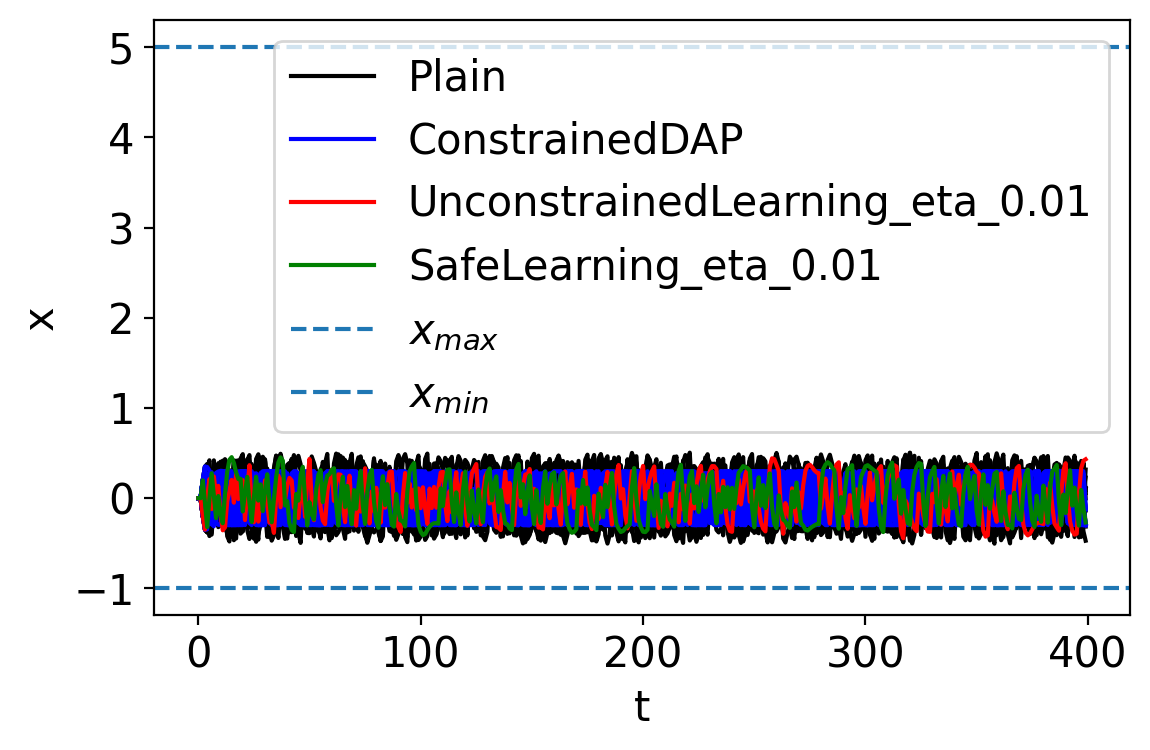

In [10]:
alg_names =  [
                'Plain',\
#               'UnconstrainedDAP',\
              'ConstrainedDAP',\
              'UnconstrainedLearning_eta_0.01','SafeLearning_eta_0.01'\
             ]
# alg_names =  ['UnconstrainedLearning_eta_0.1','SafeLearning_eta_0.1']



plt.figure(dpi=200)

ax = plt.gca()

colors =  ['black','blue','red','green','orange']

color_map = {alg:c for (alg,c) in zip(alg_names,colors)}

# control_alg =  ['ConstrainedDAP','SafeLearning_eta_0.1']


for name in alg_names:
    
    legended=False
    for d in data[name]:
        if not legended:
            ax.plot(np.array(d['x'])[:,0,:].flatten(),c=color_map[name],label=name)
            legended=True
        else:
            ax.plot(np.array(d['x'])[:,0,:].flatten(),c=color_map[name])
        


ax.axhline(x_max,label=r'$x_{max}$',ls='dashed')
ax.axhline(x_min,label=r'$x_{min}$',ls='dashed')

# ax.set_title(name)

ax.set_xlabel('t')
ax.set_ylabel('x')

ax.legend()


plt.tight_layout()
plt.savefig('./figures/x.png')


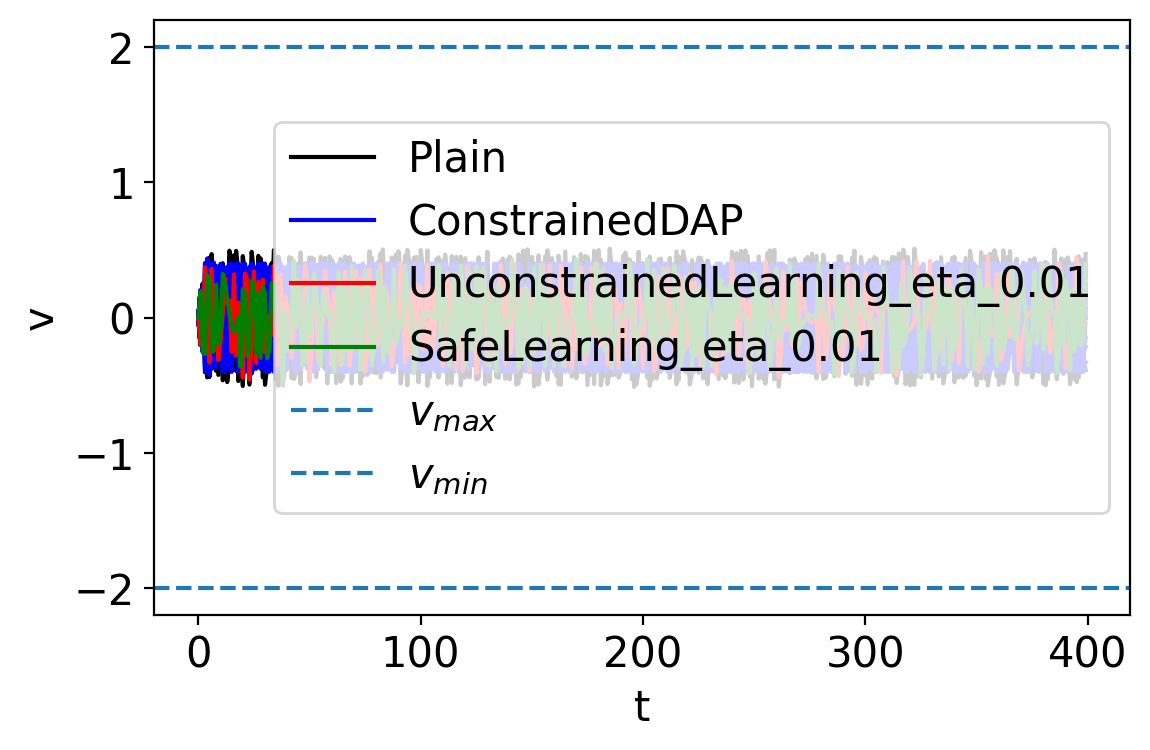

In [11]:

plt.figure(dpi=200)
ax = plt.gca()
for name in alg_names:
    
    legended=False
    for d in data[name]:
        if not legended:
            ax.plot(np.array(d['x'])[:,1,:].flatten(),c=color_map[name],label=name)
            legended=True
        else:
            ax.plot(np.array(d['x'])[:,1,:].flatten(),c=color_map[name])
        

ax.axhline(v_max,label=r'$v_{max}$',ls='dashed')
ax.axhline(v_min,label=r'$v_{min}$',ls='dashed')

ax.set_xlabel('t')
ax.set_ylabel('v')
ax.legend()


plt.tight_layout()
plt.savefig('./figures/v.png')


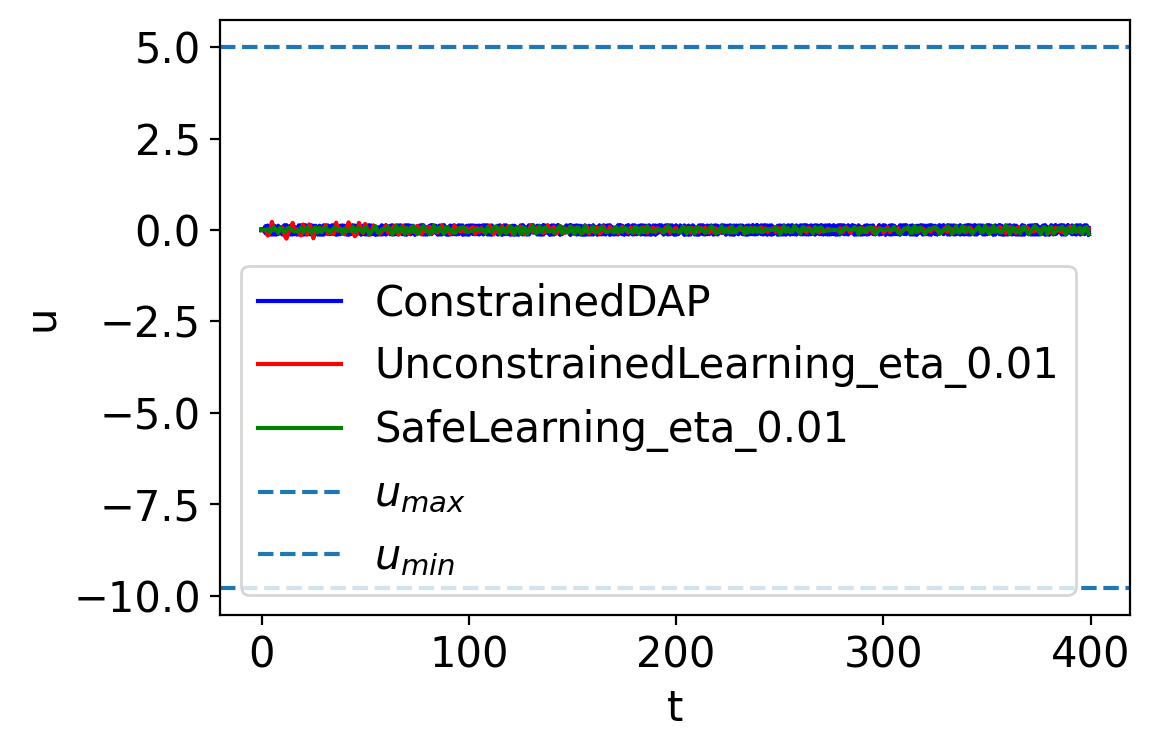

In [12]:
# control_alg = ['SafeLearning','UnconstrainedLearning']
control_alg = [
#                 'UnconstrainedDAP',
    'ConstrainedDAP',\
               'UnconstrainedLearning_eta_0.01','SafeLearning_eta_0.01'\
              ]

plt.figure(dpi=200)
ax = plt.gca()
for name in control_alg:
    
    legended=False
    for d in data[name]:
        if not legended:
            ax.plot(np.array(d['u']),c=color_map[name],label=name)
            legended=True
        else:
            ax.plot(np.array(d['u']),c=color_map[name])
  


ax.axhline(u_max,label=r'$u_{max}$',ls='dashed')
ax.axhline(u_min,label=r'$u_{min}$',ls='dashed')


ax.set_xlabel('t')
ax.set_ylabel('u')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/u.png')
